In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


In [9]:
from google.colab import files

# Upload file from local machine
uploaded = files.upload()


Saving Hotel.csv to Hotel.csv


In [10]:
# Load the dataset
file_path = "Hotel.csv"
  # Replace with your file path
df = pd.read_csv(file_path)

In [11]:
print(df.head())
print(df.info())

         Date  arrival_year  arrival_month  arrival_date room_type  \
0  2024-01-01        2024.0            1.0           1.0  Standard   
1  2024-01-01        2024.0            1.0           1.0  Standard   
2  2024-01-01        2024.0            1.0           1.0  Standard   
3  2024-01-01        2024.0            1.0           1.0  Standard   
4  2024-01-01        2024.0            1.0           1.0  Standard   

  type_of_meal_plan  total days  week_days  weekend_days  lead_time  \
0       Meal Plan 1         2.0        2.0           0.0       19.0   
1      Not Selected         5.0        5.0           0.0       39.0   
2       Meal Plan 1         3.0        3.0           0.0       23.0   
3       Meal Plan 1         3.0        3.0           0.0       19.0   
4       Meal Plan 1         2.0        2.0           0.0       11.0   

  Booking Channel  avg _price  Final price     Status  Refund  
0      hotels.com       187.0        822.8  Confirmed     0.0  
1         Expedia       

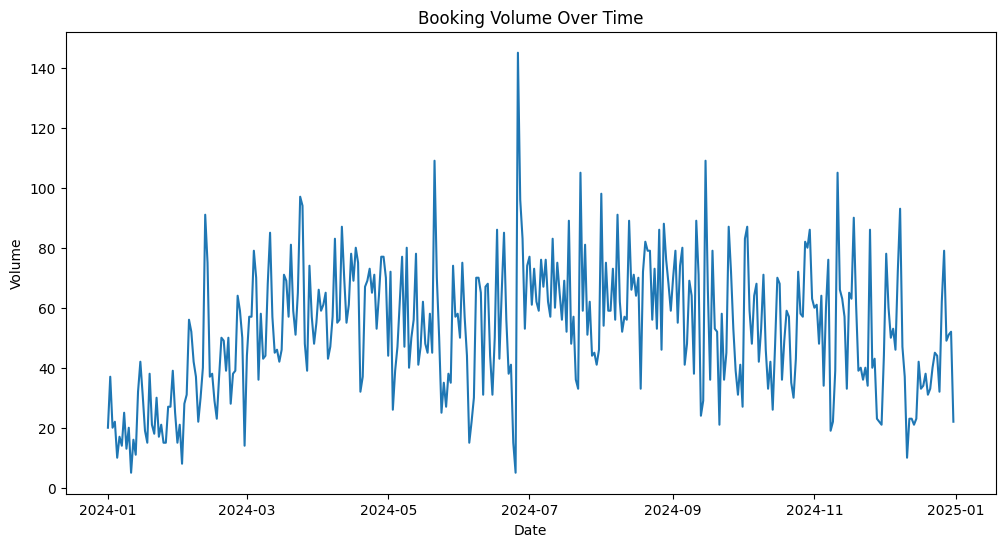

In [12]:
# Ensure 'Date' column is in datetime format
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Drop rows with invalid dates
df = df.dropna(subset=['Date'])
df= df.dropna(subset=['Booking Channel'])

# Aggregate booking volume by Date
booking_volume = df.groupby('Date').size().reset_index(name='Booking_Volume')

# Sort the data by Date
booking_volume = booking_volume.sort_values('Date')

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(booking_volume['Date'], booking_volume['Booking_Volume'])
plt.title('Booking Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.show()


In [13]:
# Create features and target variables for supervised learning
def create_features(data, lag=7):
    features, targets = [], []
    for i in range(lag, len(data)):
        features.append(data[i-lag:i])
        targets.append(data[i])
    return np.array(features), np.array(targets)

# Normalize the data
scaler = MinMaxScaler()
booking_volume['Normalized'] = scaler.fit_transform(booking_volume[['Booking_Volume']])

# Create lagged features
lag = 7  # Number of previous days to use
features, targets = create_features(booking_volume['Normalized'].values, lag)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42)



In [14]:
# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Define the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_test, y_test))


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - loss: 0.1058 - val_loss: 0.0202
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0273 - val_loss: 0.0196
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0202 - val_loss: 0.0218
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0228 - val_loss: 0.0195
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0182 - val_loss: 0.0193
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0183 - val_loss: 0.0192
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0204 - val_loss: 0.0191
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0187 - val_loss: 0.0190
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0198 - val_loss: 0.0189
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0177 - val_loss: 0.0189
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0189 - val_loss: 0.0188
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0209 - val_loss: 0.0188
Epoch 13/20

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


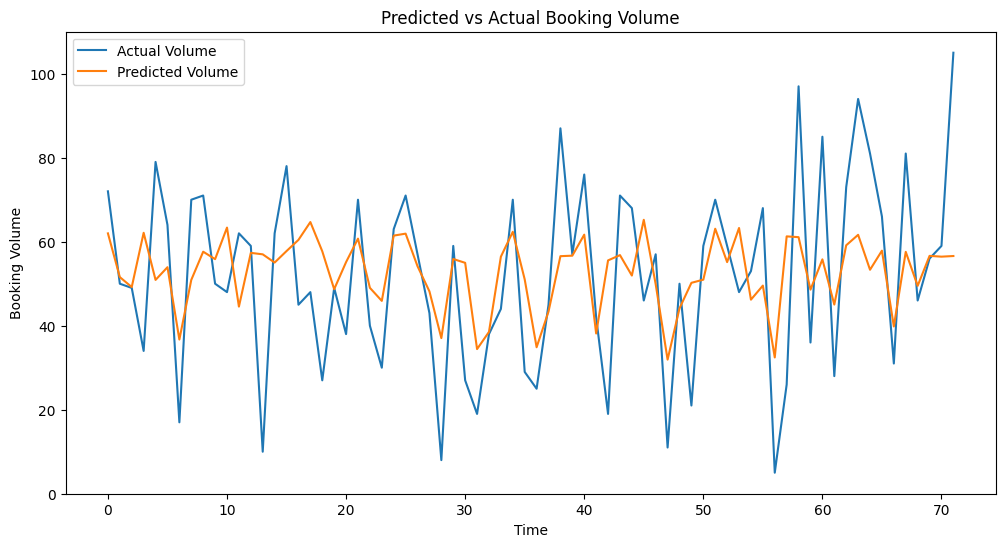

In [15]:
# Make predictions
predictions = model.predict(X_test)

# Reverse normalization for interpretation
predicted_volume = scaler.inverse_transform(predictions)
actual_volume = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot predictions vs actual
plt.figure(figsize=(12, 6))
plt.plot(actual_volume, label='Actual Volume')
plt.plot(predicted_volume, label='Predicted Volume')
plt.title('Predicted vs Actual Booking Volume')
plt.xlabel('Time')
plt.ylabel('Booking Volume')
plt.legend()
plt.show()



In [16]:
import pickle

# Save the scaler
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

# Save the LSTM model
model.save('booking_volume_model.h5')


In [17]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.4/23.4 MB 60.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 83.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.3 MB/s eta 0:00:00


In [18]:
import streamlit as st
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
import pickle

# Load the model and scaler
model = load_model('booking_volume_model.h5')
with open('scaler.pkl', 'rb') as file:
    scaler = pickle.load(file)

# Streamlit App Interface
st.title('Booking Volume Prediction')

st.write("Enter the last 7 days of booking volume:")

# Input boxes for the last 7 days of booking volume
day_1 = st.number_input('Day 1', min_value=0)
day_2 = st.number_input('Day 2', min_value=0)
day_3 = st.number_input('Day 3', min_value=0)
day_4 = st.number_input('Day 4', min_value=0)
day_5 = st.number_input('Day 5', min_value=0)
day_6 = st.number_input('Day 6', min_value=0)
day_7 = st.number_input('Day 7', min_value=0)

# Button to predict
if st.button('Predict'):
    # Prepare the input data
    input_data = np.array([day_1, day_2, day_3, day_4, day_5, day_6, day_7]).reshape(1, 7, 1)

    # Predict booking volume
    prediction = model.predict(input_data)

    # Reverse normalization
    predicted_volume = scaler.inverse_transform(prediction)

    # Display the result
    st.write(f"Predicted Booking Volume: {predicted_volume[0][0]}")


2024-12-11 02:36:56.841 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-11 02:36:57.009 
  command:

    streamlit run /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2024-12-11 02:36:57.014 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-11 02:36:57.016 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-11 02:36:57.018 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-11 02:36:57.020 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-11 02:36:57.021 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-11 02:36:57.023 Thread 'MainThread': mi

In [19]:
import os

# Create the 'models' directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Now you can create the placeholder files
open('models/booking_volume_model.h5', 'w').close()
open('models/scaler.pkl', 'w').close()

In [20]:
from tensorflow.keras.models import Sequential

# Example model creation
model = Sequential()  # Define your model here
# After training...
model.save('models/booking_volume_model.h5')  # Save model to file

In [33]:
import pickle
from sklearn.preprocessing import MinMaxScaler

In [43]:
# Select only numeric columns for scaling
numeric_columns = df.select_dtypes(include=['number']).columns
numeric_data = df[numeric_columns]

# Handle missing values, if any (e.g., fill with median)
numeric_data = numeric_data.fillna(numeric_data.median())

# Initialize and fit the scaler
scaler = MinMaxScaler()
scaler.fit(numeric_data)

# Save the fitted scaler to a file
with open('models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("Scaler has been saved successfully!")

Scaler has been saved successfully!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!streamlit run app.py

Usage: streamlit run [OPTIONS] TARGET [ARGS]...
Try 'streamlit run --help' for help.

Error: Invalid value: File does not exist: app.py
